### Reduce dimensionality of dataset using UMAP, then cluster the dataset using HDBSCAN
 - Compare the clustering of the dataset using HDBSCAN to the hand-labels

#### Import packages

In [56]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline  
import os
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import hdbscan 
import seaborn as sns
import umap
from sklearn import metrics

In [2]:
from avgn.network_analysis.network_analysis import *
import avgn.network.convnet_model as conv
from avgn.network.training import *

#### Define data parameters

In [3]:
dims = [128, 128, 1] # first dimension of input data
batch_size = 16 # size of batches to use (per GPU)

### Load the dataset

In [4]:
from glob import glob

In [5]:
bird_name = 'CAVI' 

In [6]:
hdf_locs = glob('../../../data/CAVI_wavs/*_'+str(dims[0])+'.hdf5')
hdf_locs[:3]

['../../../data/CAVI_wavs/YBuA_128.hdf5',
 '../../../data/CAVI_wavs/GRA_128.hdf5',
 '../../../data/CAVI_wavs/YAW_128.hdf5']

In [7]:
# What information is stored in the HDF5 file
to_load = ['spectrograms', 'lengths', 'start', 'wav_file', 'syll_start_rel_wav', 'symbols']

all_content = load_from_hdf5(hdf_locs, to_load, min_ex=2500, verbose=True)
num_examples = len(all_content['name'])

../../../data/CAVI_wavs/GRA_128.hdf5 3045
../../../data/CAVI_wavs/YAW_128.hdf5 3149
../../../data/CAVI_wavs/AGBk_128.hdf5 8185
../../../data/CAVI_wavs/AGO_128.hdf5 3869
../../../data/CAVI_wavs/WABk_128.hdf5 6430
../../../data/CAVI_wavs/BuRA_128.hdf5 5527
../../../data/CAVI_wavs/AOBu_128.hdf5 7638
../../../data/CAVI_wavs/ORA_128.hdf5 2805
../../../data/CAVI_wavs/RYA_128.hdf5 3565


#### Plot a few examples

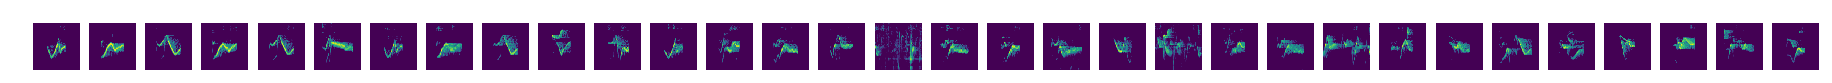

In [8]:
nex=32
fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(nex,1))
for i in range(nex):
    ax[i].matshow(all_content['spectrograms'][i].reshape((dims[0],dims[1])),
                  cmap=plt.cm.viridis, interpolation='nearest', origin='lower')
    ax[i].axis('off')

### Reduce image size for clustering

In [9]:
from skimage.transform import resize

In [10]:
x = all_content['spectrograms']

In [11]:
x_small = [resize(i, [32,32]) for i in tqdm(x)]

/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [12]:
x_small = np.array(x_small).reshape((len(x_small), np.prod(np.shape(x_small)[1:])))

### UMAP embedding

In [13]:
breakme

NameError: name 'breakme' is not defined

In [16]:
x_small[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [22]:
x_small = [(i*255).astype('uint8') for i in x_small]

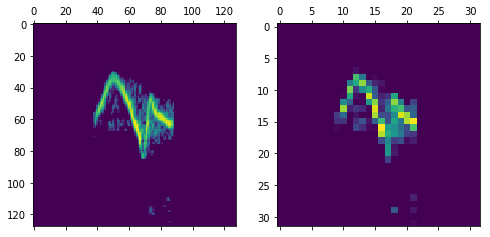

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
ax[0].matshow(x[0].reshape([128,128]))
ax[1].matshow(x_small[0].reshape([32,32]))

In [28]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    #min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(x_small)

In [29]:
np.unique(all_content['symbols'])

array([b'Chatter', b'Missed some phrases',
       b'See 1026 from 2012 mine CAVI', b'Uncertainty', b'aa', b'ab',
       b'ac', b'ad', b'ae', b'af', b'ag', b'ah', b'ai', b'aj', b'ak',
       b'am', b'an', b'ao', b'ap', b'aq', b'ar', b'as', b'au', b'ba',
       b'bc', b'bd', b'be', b'bf', b'bg', b'bi', b'bj', b'bl', b'bm',
       b'bp', b'bq', b'br', b'bu', b'bx', b'bz', b'ca', b'cb', b'cc',
       b'cd', b'ce', b'cf', b'cg', b'ch', b'chatter', b'ci', b'cj', b'ck',
       b'cl', b'cm', b'cn', b'co', b'cp', b'cr', b'da', b'db', b'dd',
       b'df', b'dg', b'dh', b'di', b'dl', b'dm', b'dn', b'do', b'dp',
       b'dr', b'ds', b'ea', b'ec', b'ed', b'eg', b'eh', b'ei', b'ej',
       b'ek', b'el', b'em', b'en', b'eo', b'eq', b'er', b'fa', b'fb',
       b'fc', b'fe', b'ff', b'fg', b'fi', b'fq', b'ha', b'hb', b'hc',
       b'hd', b'he', b'hg', b'hh', b'hi', b'hj', b'hk', b'hl', b'hp',
       b'ia', b'ib', b'ic', b'if', b'ih', b'ii', b'ij', b'ik', b'il',
       b'im', b'in', b'io', b'ip', b'iq', 

In [ ]:
plt.plot(clusterable_embedding[:,0], clusterable_embedding[:,1])

In [33]:
unique_sylls = np.unique(all_content['symbols'])
len(unique_sylls)

125

### Cluster UMAP representations

In [34]:
# we set the minimum cluster size at 0.25% of the dataset ()
cluster_pct = 0.0025

In [37]:
min_cluster_size = int(len(clusterable_embedding)*cluster_pct)
min_cluster_size

117

In [38]:
clustered_labels = cluster_data(np.array(list(clusterable_embedding)),
                          hdbscan.HDBSCAN,
                          (),
                          {'min_cluster_size':min_cluster_size,  'min_samples':1},
                         verbose = True)

Clustering took 4.81 s


In [40]:
# check how many syllables were labelled
pct_unlabelled = np.sum(clustered_labels == -1)/len(clustered_labels)
print(str(round(pct_unlabelled*100,1))+ '% of syllables went unlabelled')

1.1% of syllables went unlabelled


### Compare hand labels to UMAP embeddings (visually)

In [51]:
def plot_with_labels(data, labels, title = '', ax = None, figsize = (9,9)):
    palette = sns.color_palette('husl', len(np.unique(labels)))
    labs_to_numbers_dict = {l:i for i,l in enumerate(np.unique(labels))}
    np.random.shuffle(palette)
    colors = [palette[labs_to_numbers_dict[x]] if x >= 0 else (0.75, 0.75, 0.75) for x in np.array(labels)]

    if not ax: fig, ax= plt.subplots(nrows=1,ncols=1,figsize=figsize)
    ax.scatter(data.T[0], data.T[1],
               color=colors, alpha = 1, linewidth= 0, s=1)
    ax.axis('off')
    ax.set_title(title)
    if not ax: plt.show()
        
def compareLabellingSchemes(lab1, lab2, z, figsize=(24,24)):
    # get palette for first labelling
    palette = sns.color_palette('husl', len(np.unique(lab1)))
    labs_to_numbers_dict = {l:i for i,l in enumerate(np.unique(lab1))}
    np.random.shuffle(palette)
    colors = [palette[labs_to_numbers_dict[x]] if int(x) >= 0 else (0.75, 0.75, 0.75) for x in np.array(lab1)]
    
    # plot first labelling
    fig, ax= plt.subplots(nrows=1,ncols=1,figsize=figsize)
    ax.scatter(z.T[0], z.T[1],
               color=colors, alpha = 1, linewidth= 0, s=10)
    ax.axis('off')
    plt.show()
    
    # compare labels
    used_labs = []
    unchanged_labs = []
    for lab in np.unique(lab2):
        lab1_labs = lab1[lab2 == lab]
        closest_lab = np.unique(lab1_labs)[np.argmax([list(lab1_labs).count(i) for i in np.unique(lab1_labs)])]
        if closest_lab not in used_labs:
            used_labs.append(closest_lab)
            lab2[lab2 == lab] = closest_lab
        else: 
            unchanged_labs.append(lab)
    
    # get palette for second labelling
    palette = palette + sns.hls_palette(len(np.unique(unchanged_labs)), l=.5, s=.8)
    ul = len(np.unique(lab1))
    for ilab, lab in enumerate(unchanged_labs):
        labs_to_numbers_dict[lab] = ilab + ul
    colors = [palette[labs_to_numbers_dict[x]] for x in np.array(lab2)]
    
    fig, ax= plt.subplots(nrows=1,ncols=1,figsize=figsize)
    ax.scatter(z.T[0], z.T[1],
               color=colors, alpha = 1, linewidth= 0, s=10)
    ax.axis('off')
    plt.show()

In [52]:
lab1 = clustered_labels.astype('str')
lab2 = all_content['symbols'].astype('str')

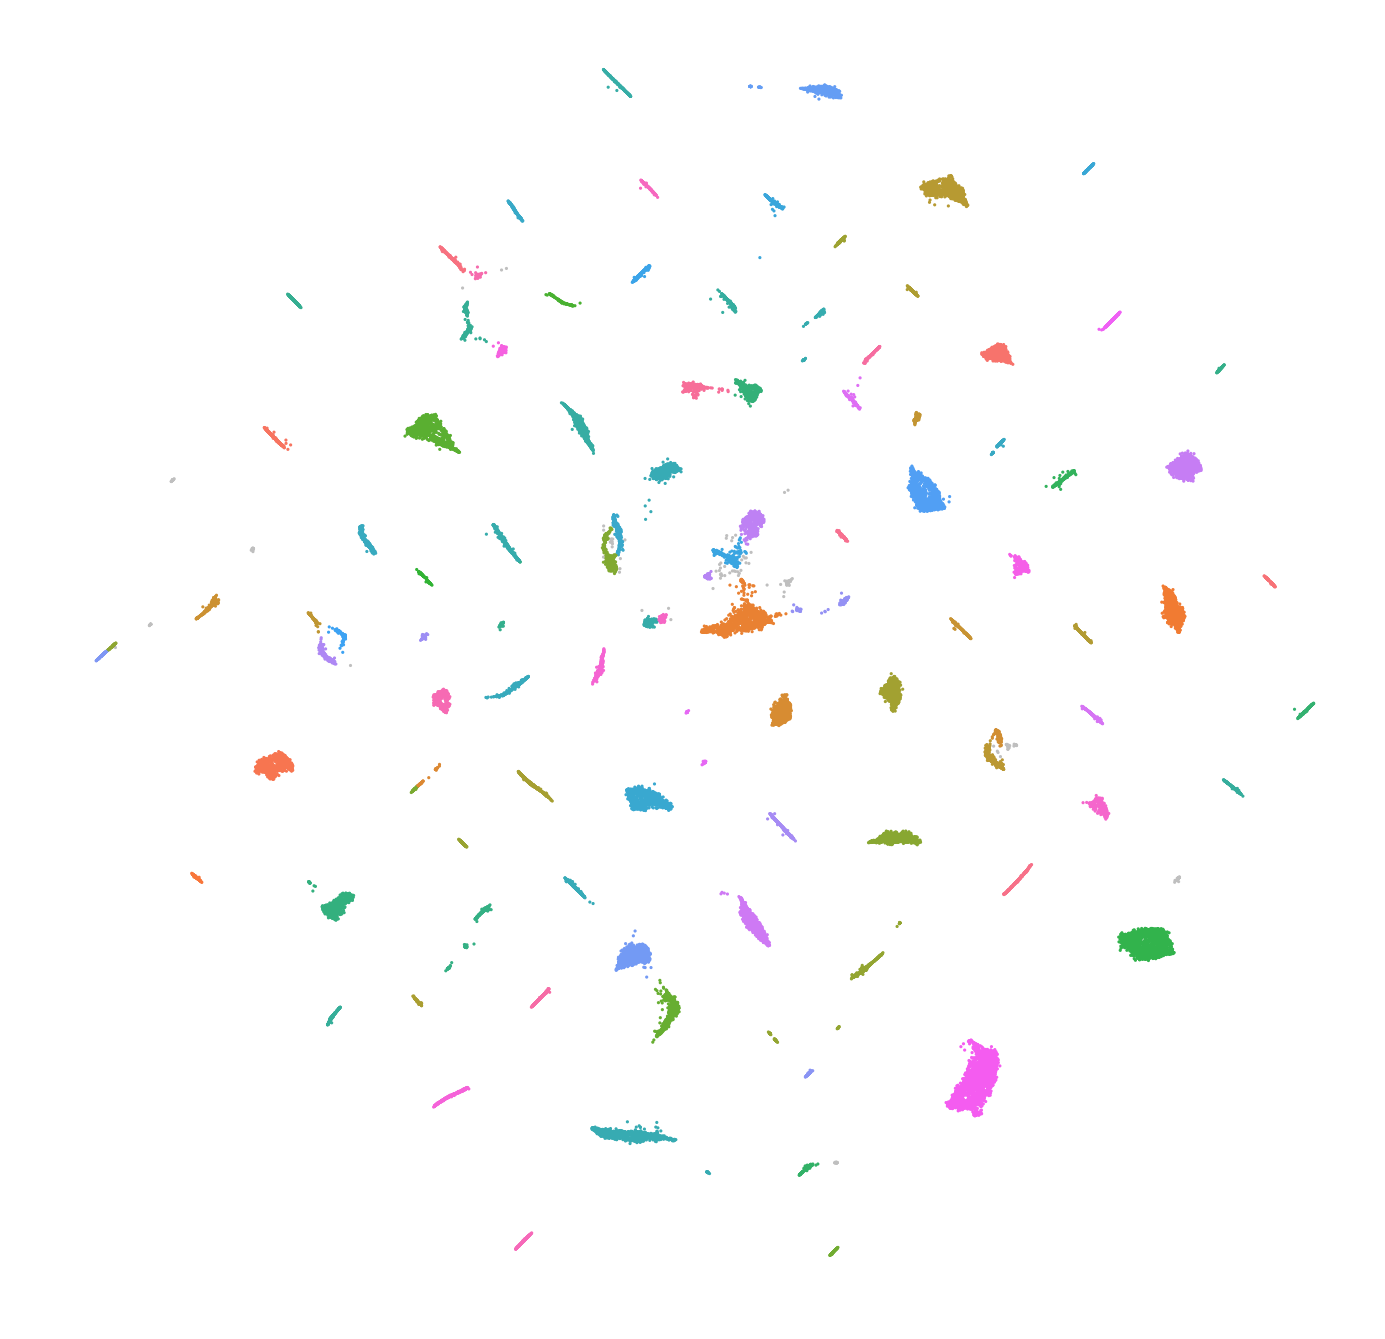

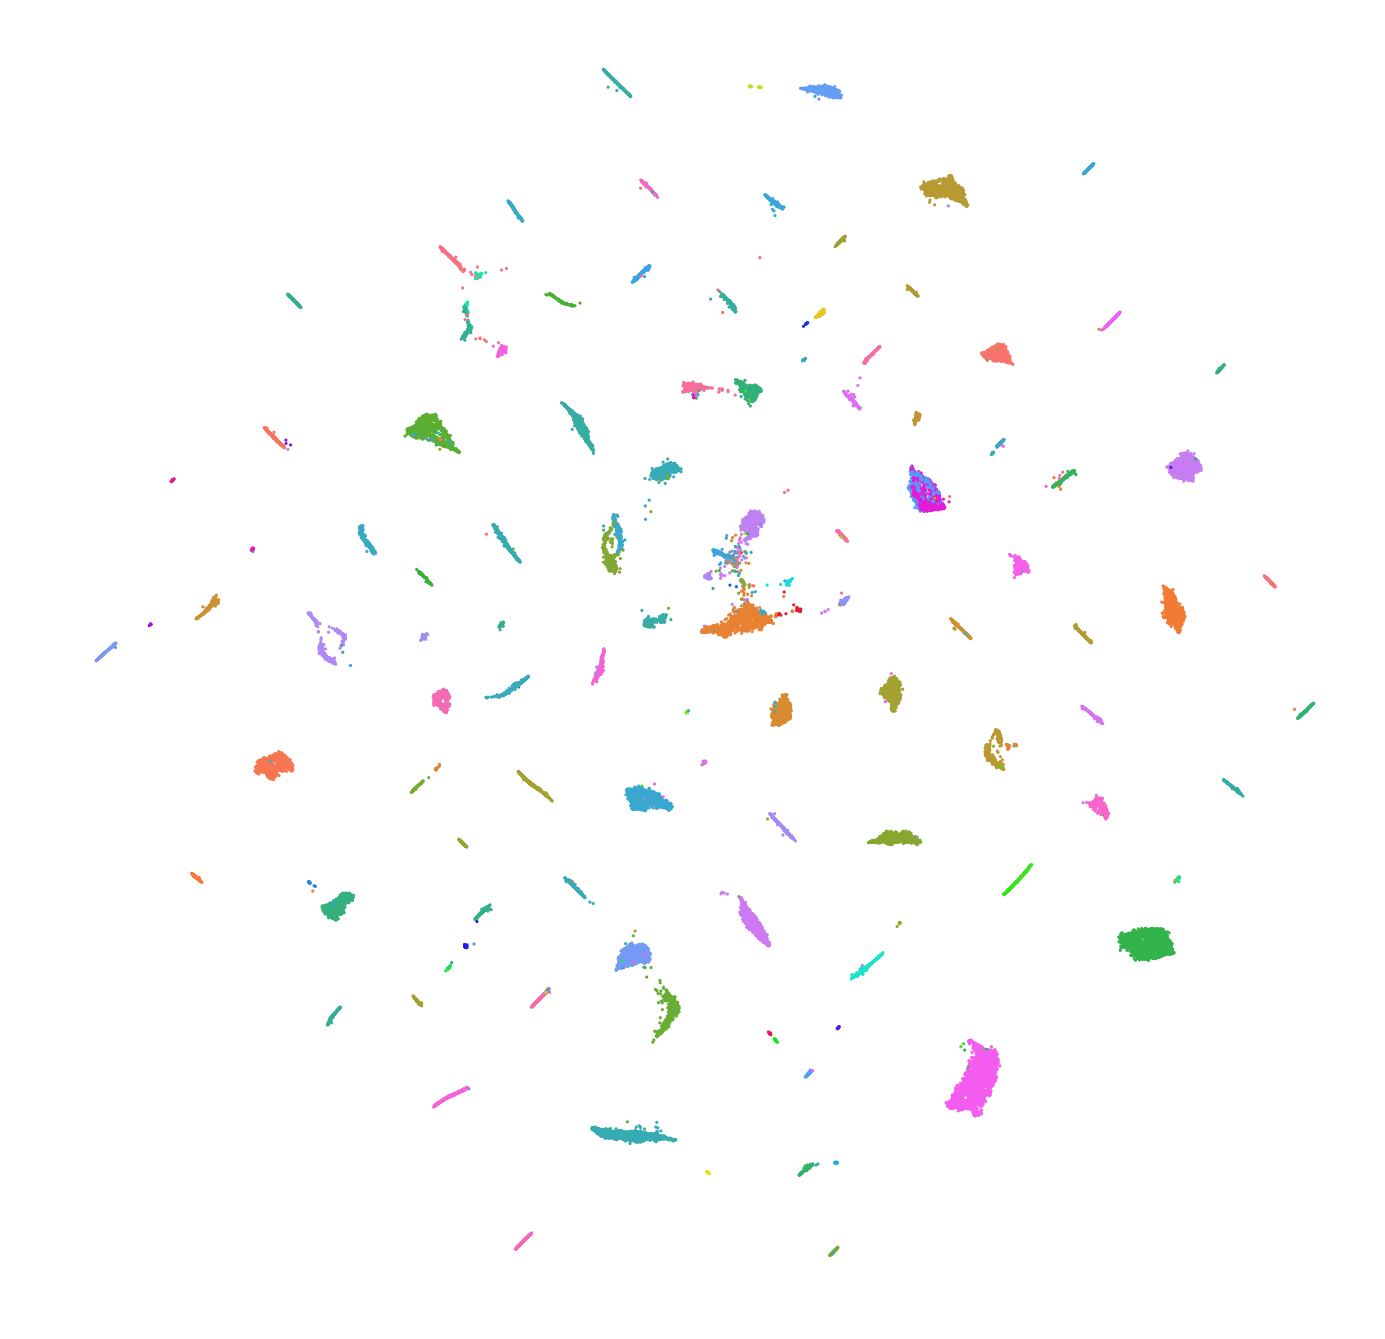

In [53]:
compareLabellingSchemes(lab1, lab2, clusterable_embedding)

### Compare hand labels to UMAP embeddings (clustering metrics)

In [57]:
# score everything
print(
    metrics.fowlkes_mallows_score(lab1,lab2),
    metrics.homogeneity_score(lab1,lab2),
    metrics.completeness_score(lab1,lab2),
    metrics.v_measure_score(lab1,lab2),
    metrics.adjusted_mutual_info_score(lab1,lab2),
    metrics.normalized_mutual_info_score(lab1,lab2),
    metrics.adjusted_rand_score(lab1,lab2)
)

0.9452410662681358 0.971396199401056 0.9624495297210622 0.9669021692963962 0.9613175997470076 0.966912516873359 0.9443169799857183


In [58]:
#score only clustered
mask = lab1 != '-1'
print(
    metrics.fowlkes_mallows_score(lab1[mask],lab2[mask]),
    metrics.homogeneity_score(lab1[mask],lab2[mask]),
    metrics.completeness_score(lab1[mask],lab2[mask]),
    metrics.v_measure_score(lab1[mask],lab2[mask]),
    metrics.adjusted_mutual_info_score(lab1[mask],lab2[mask]),
    metrics.normalized_mutual_info_score(lab1[mask],lab2[mask]),
    metrics.adjusted_rand_score(lab1[mask],lab2[mask])
)

0.9494495177389296 0.973171962020301 0.967913234313239 0.9705354747759087 0.9669890320217023 0.9705390364648039 0.9486023214378893
